<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/Q_learning_dirichlet_2d_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]

- [previous version](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)


__Problem setup__

We want to solve a d-dimensions HJB
$$\inf_a \{\sum_{i=1}^db_i(x,a)  \frac{\partial v(x)}{\partial x_i}  + \frac 1 2 \sum_{i,j=1}^{d} \hat \sigma_{ij} \frac{\partial^2 v(x)}{\partial x_i \partial x_j} - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ where } \hat \sigma _{ij} = \sigma*\sigma^T , \sum_{i=1}^{d}x_i^2\leq1$$
with Dirichlet data
$$v(x_1,x_2,..,x_d) = g(x_1,x_2,..,x_d), \quad \hbox{ when } \sum_{i=1}^{d}x_i^2 = 1$$




__MDP discretization__

Approximation:
$$
\frac{\partial v(x)}{\partial x_i} \leftarrow \frac{v(x+e_ih)-v(x-e_ih)}{2h}
$$
when $i = j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih)-2v(x)+v(x-e_ih)}{h^2}
$$
when $i \neq j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh)}{4h^2}
$$
then
$$\inf_a \{v(x)(-\lambda-\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2})+\sum_{i=1}^{d}v(x+e_ih)\frac{b_i(x,a)h+\sigma_{ii}}{2h^2}+\sum_{i=1}^{d}v(x-e_ih)\frac{-b_i(x,a)h+\sigma_{ii}}{2h^2}+    \\
\sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))\frac{\hat \sigma_{ij}}{8h^2}+ \ell(x,a)\} = 0
$$
Set
$$
c_1 = \lambda+\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2}
$$
$$
\Lambda = \frac{\sum_{i=1}^{d}\frac{\lambda h^2+\sigma_{ii}}{h^2}}{\sum_{i=1}^{d}\frac{\sigma_{ii}}{h^2}}=\frac{\lambda h^2+\sum_{i=1}^{d}{\sigma_{ii}}}{\sum_{i=1}^{d}\sigma_{ii}}
$$
Then
$$
p^h(x+e_ih|x_i, a_i) = \Lambda \cdot (\frac{b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x-e_ih|x_i, a_i) = \Lambda \cdot (\frac{-b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x \pm e_ih \pm e_jh|x_i, x_j) = \Lambda \cdot \frac{\hat \sigma_{ij}}{8h^2}
$$
$$
 \hat \ell(x,a)=\frac{\ell(x,a)}{c_1}
$$
so 

$$
v(x) = \inf_a\{\sum_{i=1}^{d}p^h(x+e_ih|x_i, a_i)v(x+e_ih) +\sum_{i=1}^{d}p^h(x-e_ih|x_i, a_i)v(x-e_ih) \\
+ \sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))p^h(x \pm e_ih \pm e_jh|x_i, x_j) + \hat \ell(x,a) \}
$$

__Example__
$$
\inf_a(a \bigtriangledown v + \frac 1 2 \bigtriangleup v +d + 2|x|^2 + \frac 1 2 |a| ^2)
$$

where
$$
v(x) = g(x) = -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)\\
$$
In this case
$$
b(x,a) = (a_1, a_2,...,a_d) \\
\begin{equation*}
\hat \sigma =\begin{bmatrix}
1 & 0&\dots & 0\\
0 &1 &\dots &0\\
0 & 0 &\dots & 1
\end{bmatrix}_{d\times d}
\end{equation*}
$$
$$
\ell(x,a) = d + 2|x|^2 + \frac 1 2 |a|^2
$$
the exact solution is 
$$
v(x) =  -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

In [0]:
#PDE to be solved
class pde:
  def __init__(self,dim,NUM):
    #pde config
    self.name = 'HJB nd'
    self.dim = dim
    self.NUM = NUM
    self.LIM = 1 #limit for state
    self.h = 1./self.NUM #mesh size in state space

    self.lambda_ = 0. #discount rate
    self.sigma = np.eye(self.dim) #diffusion coefficient matrix
    
    
    
    self.x_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
    self.a_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
    self.s_val = np.zeros(self.x_space.size*np.ones(self.dim, np.int))
    self.q_table = np.zeros(np.append(self.x_space.size*np.ones(self.dim, np.int),self.a_space.size*np.ones(self.dim, np.int)))
    self.term_ind_space = np.array([0, self.x_space.size-1]) #space of terminal state indice
    
    self.drift = lambda x,a: a  #drift coefficient function

    self.run_cost = lambda x,a: self.dim + 2*np.sum(np.power(x,2)) + (1/2)*np.sum(np.power(a,2))
    
    self.term_cost = lambda x: -np.sum(np.power(x,2))
    
    #pde exact solution if available
    self.exact_sol = self.term_cost

    

In [0]:
def mdp_space_config(self):

  print('>>>>> q_table size is %i' %(self.q_table.size))

  #s_val and q-table terminal setup
  for i in range(self.s_val.size):  # visit all x States
    k = self.dim - 1
    x_d = []          
    s_index = []
    Limit = 0
    while k >= 0:
      x_d.append(self.x_space[(i//(self.x_space.size**k))%self.x_space.size])
      s_index.append((i//(self.x_space.size**k))%self.x_space.size)
      Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
      k -= 1
    if (0 in s_index) or ((len(self.x_space) - 1) in s_index): # visit the terminal condition 
      self.s_val[tuple(s_index)] = self.term_cost(x_d)
      for j in range(self.a_space.size**self.dim):
        m = self.dim - 1
        a_index = []
        while m >= 0:
          a_index.append((i//(self.a_space.size**m))%self.a_space.size)
          m -= 1
        self.q_table[tuple(s_index + a_index)] = self.term_cost(x_d)
  
pde.mdp_space_config = mdp_space_config

In [0]:
#transition probability
#output is probability (np array) on del_ind_space 
#central fdm

def mdp_trans_prob_central(self,x,a,sigma):
  tp_right = np.zeros((self.dim,self.dim))
  tp_left = np.zeros((self.dim,self.dim))
  b_ = self.drift(x,a)
  
  c1 = self.lambda_ + sum(sigma.diagonal())/(self.h**2)
  Lambda = 1 + self.lambda_*(self.h**2)/sum(self.sigma.diagonal())
  
  tp_right =Lambda*sigma/(8*c1*self.h**2)
  tp_left = Lambda*sigma/(8*c1*self.h**2)
  
  p_right = Lambda*((b_*self.h + sigma.diagonal())/(2*c1*self.h**2))
  p_left = Lambda*((-1*b_*self.h + sigma.diagonal())/(2*c1*self.h**2))
  for i in range(self.dim):
    tp_right[i,i] = p_right[i]
    tp_left[i,i] = p_left[i]

  discount = 1+2*np.sum(Lambda*sigma/(8*c1*self.h**2)) - 2*np.sum((Lambda*sigma/(8*c1*self.h**2)).diagonal())
  tp_right = tp_right/(discount - np.sum(p_left))
  tp_left = tp_left/(discount - np.sum(p_right))


  return tp_right, tp_left 

pde.mdp_trans_prob_central = mdp_trans_prob_central

In [0]:
def q_learning(self, 
               n_epoch = 50000, #tolerance for iteration
               learning_rate = 0.01, #maximum iteration
                start_state = np.array([0,0])
              ):
 
  start_ind = ((start_state + 1)/0.1).astype(int)
  Lambda_ = 1 + self.lambda_*(self.h**2)/sum(self.sigma.diagonal())# reciprocal of discount factor

  for epoch in tqdm(range(n_epoch)):
    now_ind_ = start_ind.copy() #start
    while (np.min(now_ind_) != 0 and np.max(now_ind_) != (self.x_space.size - 1)):
      if np.random.random() > 0.05:
        res = np.where(self.q_table[tuple(now_ind_)] == np.min(self.q_table[tuple(now_ind_)])) #choose action index
        act_ind_ = np.array([res[i][0] for i in range(len(res))])

      else:
        act_ind_ = np.array([np.random.randint(self.a_space.size),np.random.randint(self.a_space.size)])

      x_ = np.array([self.x_space[now_ind_[0]],self.x_space[now_ind_[1]]]) #current state
      a_ = np.array([self.a_space[int(act_ind_[0])],self.a_space[int(act_ind_[1])]]) #current action
      c1 = self.lambda_ + sum(self.sigma.diagonal())/(self.h**2)
      run_cost_ = (self.run_cost(x_,a_))/c1
      
      tp_right, tp_left = self.mdp_trans_prob_central(x_, a_, self.sigma)
      sampling_ = np.random.binomial(1, 0.5)
      index_ = np.arange(self.dim**2)
  
      temp = 0
      next_ind_ = now_ind_.copy()

      if sampling_ == 0:
        
        temp = np.random.choice(index_,1,p=tp_right.reshape(self.dim**2))
        
        if temp//self.dim != temp%self.dim:
          
          next_ind_[temp//self.dim] = now_ind_[temp//self.dim] + 1
          next_ind_[temp%self.dim] = now_ind_[temp%self.dim] + 1
          
        else:
          next_ind_[temp//self.dim] = now_ind_[temp//self.dim] + 1
      else:
        
        temp = np.random.choice(index_,1,p=tp_left.reshape(self.dim**2))
        
        if temp//self.dim != temp%self.dim:
          
          next_ind_[temp//self.dim] = now_ind_[temp//self.dim] - 1
          next_ind_[temp%self.dim] = now_ind_[temp%self.dim] - 1
          
        else:
          next_ind_[temp//self.dim] = now_ind_[temp//self.dim] - 1 
      del_q = run_cost_ + self.s_val[tuple(next_ind_)]/Lambda_ - self.q_table[tuple(np.append(now_ind_, act_ind_))]
      self.q_table[tuple(np.append(now_ind_, act_ind_))] += learning_rate*del_q
      self.s_val[tuple(now_ind_)] = np.min(self.q_table[tuple(now_ind_)]) #sync q_table with s_val
      now_ind_ = next_ind_.copy()

  return self.s_val[start_ind]
      
pde.q_learning = q_learning    

In [8]:
pde1 = pde(dim=2,NUM=10)
pde1.mdp_space_config()
pde1.q_learning()

>>>>> q_table size is 194481


100%|██████████| 50000/50000 [20:34<00:00, 40.50it/s]


array([[-1.        , -0.66345204, -0.42008995, -0.23122535, -0.09556699,
        -0.02530353,  0.00723151,  0.01127601,  0.01456211,  0.01935684,
         0.02415316,  0.01942637,  0.01459881,  0.01123679,  0.00613071,
        -0.02838615, -0.11873093, -0.23647934, -0.4064711 , -0.65802873,
        -1.        ],
       [-1.        , -0.66345204, -0.42008995, -0.23122535, -0.09556699,
        -0.02530353,  0.00723151,  0.01127601,  0.01456211,  0.01935684,
         0.02415316,  0.01942637,  0.01459881,  0.01123679,  0.00613071,
        -0.02838615, -0.11873093, -0.23647934, -0.4064711 , -0.65802873,
        -1.        ]])

In [9]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 1235.454140 seconds


>>>max norm of error is 0.3508297794434206
>>>Percentage of error is 0.24113491412339946


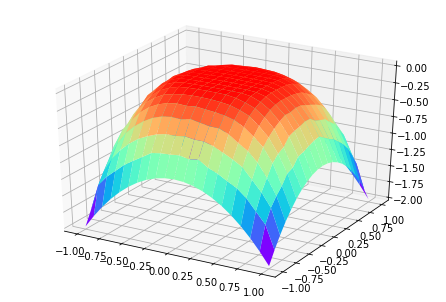

In [10]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z1 = pde1.s_val
Z = -(X1)**2 - (X2)**2
axes.plot_surface(X1, X2, Z1,cmap='rainbow')
print('>>>max norm of error is ' + str(np.max(np.abs(Z-Z1))))
print('>>>Percentage of error is ' + str(np.sum(np.abs(Z-Z1))/np.sum(np.abs(Z))))